In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imagehash
from collections import Counter
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# **AI generated vs real images detection. Classifying deepfake and real images**

## **ABSTRACT**

This will be added in the end........


## **1.Introduction**

The rapid advancements in artificial intelligence have transformed the field of image generation (Stephan Bohm et al., n.d.)[1] . Modern generative models, such as Generative Adversarial Networks (Goodfellow et al., 2014)[2] and Latent Diffusion Models (Rombach et al., 2021)[3], can produce almost realistic images that are often indistinguishable from those created by humans. This technology has enabled innovative applications in art, design, and entertainment (Van Waning, 2024)[4] . However, it also introduces significant concerns, particularly around misinformation, intellectual property, ethical usage, digital security, and public trust (Kamali et al., 2024)[5].

AI-generated images are a double-edged sword. While they empower creative industries and expand access to content creation tools, they also pose serious societal risks (Stephan Bohm et al., n.d.)[1]. Misinformation is a major concern, as fake images can be used to spread false information, influence opinions, or create fake evidence. For example, an AI-generated image could falsely show someone committing a crime, damaging their reputation or affecting legal cases. (Bird & Lotfi, 2023) [6]

The risks extend to cybersecurity, where AI-generated human faces and biometric data have been used to bypass security systems. Additionally, the rise of deepfake technology amplifies these challenges, eroding trust in visual media and complicating the work of journalists, law enforcement, and other stakeholders who rely on image authenticity. (Bird & Lotfi, 2023) [6]

Although people can often notice small visual clues in fake images, modern AI is becoming so advanced that it’s harder to spot the difference. Unlike earlier generations, which exhibited obvious flaws, modern synthetic images seamlessly mimic real-world details. However, certain artifacts—such as anatomical errors (e.g., malformed hands), stylistic inconsistencies (e.g., unnatural lighting), and sociocultural inaccuracies (e.g., cultural norm violations)—can still serve as critical indicators for detection (Kamali et al., 2024)[5] Ediboglu and Akyol (2023)[7].

This project aims to ................................................

## **2.Related work**

Various methods have been proposed for distinguishing AI-generated images from real ones. ResNets (He et al., 2015)[8] , a type of convolutional neural network (CNN) (O’Shea & Nash, 2015)[9], are widely used due to their ability to analyze high-level features while mitigating the vanishing gradient problem with residual connections. These properties allow ResNets to often outperform other models in classification tasks by learning intricate patterns and textures in images. Ediboglu and Akyol (2023)[7] (Bird & Lotfi, 2023) [6]

CNNs more broadly remain a reliable choice for feature extraction and classification. Their ability to process spatial hierarchies in image data makes them highly effective for identifying subtle differences between real and AI-generated images. CNNs are frequently used as a foundation for other advanced models.(Maruthiram et al., 2024)[10].

Variational Autoencoders (VAEs) (Kingma & Welling, 2013)[11] have also been explored, primarily for anomaly detection. By reconstructing input images and identifying deviations from natural patterns, VAEs can highlight inconsistencies in synthetic images. However, they tend to underperform compared to discriminative models like ResNets when applied to complex datasets such as CIFAKE. Ediboglu and Akyol (2023)[7]

Transformer-based models, such as Vision Transformer (Dosovitskiy et al., 2020)[12], have gained traction for their attention mechanisms, which enable them to capture global dependencies in image data. This makes them particularly effective at handling diverse and complex datasets. Models like Swin Transformers further enhance performance by combining hierarchical feature extraction with the efficiency of attention-based architectures. Ediboglu and Akyol (2023)[7] (Bird & Lotfi, 2023) [6] (Maruthiram et al., 2024)[10]

Finally, explainability tools, such as Grad-CAM (Selvaraju et al., 2019)[13], help to interpret model decisions by visualizing the image regions most influential in classifications. These tools often reveal that classifiers rely on subtle imperfections or artifacts in AI-generated images—features that are difficult for humans to detect but crucial for accurate classification.(Maruthiram et al., 2024)[10].

This project will build on all of these approaches, they have been used on other datasets(CIFAKE or AiARt). We will ........................................

## **3.Data acquisition, exploration and working with images**

### **Data acquisition**

The data is acquired through Kaggle and it's free for use. The dataset consists of authentic images sampled from the Shutterstock platform across various categories, including a balanced selection where one-third of the images feature humans. These authentic images are paired with their equivalents generated using state-of-the-art generative models. This structured pairing enables a direct comparison between real and AI-generated content, providing a robust foundation for developing and evaluating image authenticity detection systems. This is the official dataset for the 2025 Women in AI Kaggle Competition.

AI vs. Human-Generated Images; By: Alessandra Sala, Margarita Pitsiani, Manuela Jeyaraj, Toma Ijatomi; License: Apache 2.0 ; Link to data: https://www.kaggle.com/datasets/alessandrasala79/ai-vs-human-generated-dataset/data

To note: No one from the above mentioned has worked on the same dataset as this one.

NOTE: I am working on v1 of the dataset, which was updated on 22/01/2025. The difference with v2 is that v2 has the same train set, but a smaller test set(5k files) with different images than the ones I have in v1.

### **Data overview and loading**
1. Let's look at the csv file to see whether it's tidy, has any missing values or duplicates and gain more knowledge about the dataset .

In [47]:
train_df = pd.read_csv("train.csv")
train_df

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1
...,...,...,...
79945,79945,train_data/9283b107f6274279b6f15bbe77c523aa.jpg,0
79946,79946,train_data/4c6b17fe6dd743428a45773135a10508.jpg,1
79947,79947,train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg,0
79948,79948,train_data/ff960b55f296445abb3c5f304b52e104.jpg,1


In [52]:
train_df.shape

(79950, 3)

2. As we can see we have 79950 observations corresponding to the 79950 training images in the dataset and 3 features. Features being the name of the image(file_name) and the corresponding label(0 or 1) and an Unnamed feature.
3. The names of the columns are in snake_case already, which makes work better.
4. From first sight I can see somewhat redundant train_data/ path that could possibly be problematic as then the path would be train_data/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg. Its not only the name of the file, it doesn't need the path.
5. Also the column Unnamed:0 doesn't do much and its just the same as the id so i will probably drop it.
6. Let's perform the changes

In [65]:
train_df["file_name"] = train_df["file_name"].str.replace("train_data/", "", regex=False) 
train_df = train_df.drop(columns=["Unnamed: 0"]) 

In [67]:
train_df

,file_name,label
0,a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,041be3153810433ab146bc97d5af505c.jpg,0
2,615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,8542fe161d9147be8e835e50c0de39cd.jpg,0
4,5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1
...,...,...
79945,9283b107f6274279b6f15bbe77c523aa.jpg,0
79946,4c6b17fe6dd743428a45773135a10508.jpg,1
79947,1ccbf96d04e342fd9f629ad55466b29e.jpg,0
79948,ff960b55f296445abb3c5f304b52e104.jpg,1


6. Now it looks better let's see whether we have any missing values or duplicates

In [69]:
train_df.isnull().sum()

file_name    0
label        0
dtype: int64

7. Now let's see if there are any duplicates 

In [74]:
train_df.duplicated().sum()

0

8. There are no duplicates and now let's see if the data types are correct, which could reveal a NaN value that wasn't initially found

In [80]:
train_df.dtypes

file_name    object
label         int64
dtype: object

9. The datatypes look correct, now let's see the distribution of the classes, to see whether we will be working with disbalanced dataset, which would require additional actions(sampling techniques and data gathering)

In [86]:
train_df.label.value_counts()

label
1    39975
0    39975
Name: count, dtype: int64

10. The data is perfectly seperated with even instances for class 0 and class 1.
11. Now let's see one instance from both classes to understand what we are dealing with and which class is AI generated images and which is real images

In [136]:
label_images = train_df.groupby('label').first()['file_name']
train_images_path = 'train_data'

12. Let's define a function to plot the images,

In [139]:
def plot_images(image_paths, labels, title="Label Examples"):
    """
    Plot a series of images with their corresponding labels.

    Args:
        image_paths (list of str): List of file paths to the images to be displayed.
        labels (list of int or str): List of labels corresponding to each image.
        title (str, optional): Title of the entire plot. Default is "Label Examples".

    Returns:
        None: The function displays a matplotlib plot but does not return anything.

    Example:
        image_paths = ["path/to/image1.jpg", "path/to/image2.jpg"]
        labels = [0, 1]
        plot_images(image_paths, labels, title="Sample Images")
    """
    plt.figure(figsize=(10, 5))
    for idx, (img_path, label) in enumerate(zip(image_paths, labels)):
        img = Image.open(img_path)
        plt.subplot(1, len(labels), idx + 1)
        plt.imshow(img)
        plt.title(f"Label {label}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [141]:
image_paths = [os.path.join(train_images_path, img) for img in label_images]
labels = label_images.index.tolist()

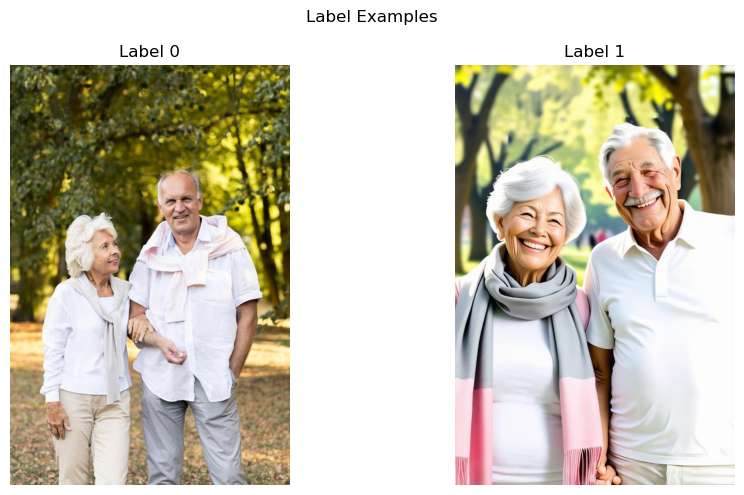

In [143]:
plot_images(image_paths, labels)

13. As it can be seen, or maybe not for everybody. The picture under label 0 is the real image. But why?
14. The obvious hints Label 1 is AI generated are:
- The overly smooth skin and details: AI often struggles with capturing realistic skin aging details, such as natural wrinkles or subtle blemishes. The skin is too smooth.
- Symmetry and unrealistic perfection: AI images may exhibit unnaturally perfect facial symmetry or expressions that look slightly exaggerated, such as overly bright smiles or perfectly aligned teeth.
- Background Details: The background elements (e.g., trees and lighting in this image) might appear slightly inconsistent or blurry, especially where the foreground and background meet. AI sometimes generates repetitive or strange patterns in the background when creating scenes.
- Clothing and Accessories: AI-generated scarves, shirts, or other clothing may have unnatural folds or textures. Look for inconsistencies, such as strange shadows or unrealistic interactions with light.
- Eye and Hair Details: Eyes may look overly sharp or glassy, and the reflections within them might not match the surrounding environment. Hair strands can appear too perfect or lack the natural messiness of real hair.
- Hands and Fingers: While this image appears focused on faces, hands and fingers in AI-generated images are often distorted, with unusual proportions or extra/missing fingers.
- General Vibe: The image might feel too staged or "perfect," almost like a stock photo but slightly off in a way that's hard to describe.

15. This dataset is structured so that every real image has it's AI generated counterpart. The csv file contains the label for the images. The idea is to train a model to be able to find the differences between AI and real image

## **4.Model training(ResNet50, EfficientNet-b0, MobileNet-V2, ConvNeXt, ViT(Visual Transformers))**

### **Model training script**

1. ImageDataset - Custom PyTorch Dataset that loads images and their corresponding labels from a CSV file.
- Reads image file names and labels from the CSV.
- Loads the images from the specified directory.
- Applies optional transformations (resize, normalization, etc.).
- Returns a tensor image and its corresponding label.

2. EarlyStopping is a class that:
- Monitors validation loss and stops training if there is no improvement after a defined number of epochs.
- Saves the best model checkpoint whenever validation loss improves.
- If the validation loss does not improve for patience epochs, training stops early.

3.  Data Preparation - Preparing Training & Validation Data
- Reads training data from a CSV file (train.csv).
- Cleans file paths (removes "train_data/" prefix).
- Splits data into 80% training and 20% validation, ensuring balanced class distribution (stratify=train_df['label']).
- Defines data augmentations for training:
- Resize images to (224, 224).
- RandomHorizontalFlip (data augmentation).
- RandomRotation (small rotations for variability).
- Convert to Tensor and Normalize using ImageNet mean/std.
- Defines validation transformations (only Resize, Normalize, ToTensor, no augmentation).

4. Data Loaders - Efficient Data Handling
- Creates PyTorch datasets (ImageDataset) for training & validation.
- Uses DataLoader to handle batch processing:
- Training DataLoader → Shuffled (shuffle=True) for randomness.
- Validation DataLoader → Not shuffled (shuffle=False) to keep order.
- Batch Size = 64 (processes 64 images at a time).
- pin_memory=True → Optimizes GPU data loading.

5.  Model Setup - Loading ResNet50 & Modifying It
- Checks if a GPU (CUDA) is available, otherwise defaults to CPU.
- Loads a pre-trained ResNet50 model (models.resnet50(pretrained=True)).
- Modifies the final fully connected (FC) layer:
- The original ResNet50 FC layer predicts 1000 classes.
- It's replaced with a single output neuron (nn.Linear(num_features, 1)) for binary classification.
- Moves the model to GPU (if available) for faster training.
- Uses Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss).
- Uses Adam optimizer (Adam(model.parameters(), lr=1e-4)) for learning.


6. load_checkpoint - Resumes Training from Last Checkpoint
- Checks if a checkpoint file exists (best_model.pth).
- If a checkpoint exists: It loads the model weights and optimizer state, retrieves the last saved epoch and best validation loss, if no checkpoint is found, training starts from scratch.


7. train_one_epoch - One Full Training Pass
- Set model to training mode → model.train().
- Loop through training batches:
- Moves images & labels to GPU/CPU.
- Feeds images into the model → Gets predictions.
- Computes loss (difference between predictions & labels).
- Backpropagates → Updates model weights.
- Returns the average training loss for the epoch.

8. validate - Evaluates Model on Validation Data and Runs validation without updating weights.
- Set model to evaluation mode → model.eval() (turns off dropout/batch norm updates).
- Loop through validation batches:
- Moves images & labels to GPU/CPU.
- Feeds images into model → Gets predictions.
- Computes validation loss.
- Converts model outputs into binary labels (0 or 1) using a 0.5 threshold.
- Computes performance metrics: (Accuracy, Precission, Recall, F1-Score, AUC)

10. Main Training Script - Runs the Full Training Process
- Loads model & optimizer.
- Loops through multiple epochs:
- Train the model (train_one_epoch).
- Validate the model (validate).
- Saves the best model (if validation loss improves).
- Stops early if no improvement for patience epochs (EarlyStopping).
- Saves training metrics (loss & accuracy) to a JSON file.


In [ ]:
# --- Custom Dataset ---
class ImageDataset(Dataset):
    """
    Custom Dataset for loading images and labels from a CSV file.
    
    Attributes:
        annotations (DataFrame): DataFrame containing image filenames and labels.
        img_dir (str): Path to the directory containing image files.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    """
    Custom Dataset class for loading images and labels from a CSV file.
    """
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = csv_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        """
        Retrieves the image and corresponding label at the given index.
        
        Args:
            idx (int): Index of the image to retrieve.
        
        Returns:
            Tuple[Tensor, Tensor]: Transformed image tensor and its corresponding label tensor.
        """
        """Returns image and label at the given index."""
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(int(self.annotations.iloc[idx, 1]))

        if self.transform:
            image = self.transform(image)

        return image, label

# --- Early Stopping ---
class EarlyStopping:
    """
    Implements early stopping to prevent overfitting during training.
    
    Attributes:
        patience (int): Number of epochs to wait before stopping if no improvement.
        verbose (bool): If True, prints messages when validation loss improves.
        counter (int): Counter for tracking consecutive epochs without improvement.
        best_loss (float, optional): Stores the best validation loss encountered.
        early_stop (bool): Flag to indicate when early stopping is triggered.
    """
    """
    Stops training when validation loss stops improving.
    """
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model, optimizer, epoch, path="best_model.pth"):
        """
        Saves model checkpoint if validation loss improves, otherwise increases counter.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_loss": self.best_loss
            }, path)
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.4f}. Checkpoint saved!")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# --- Data Preparation ---
csv_path = "train.csv"
train_df = pd.read_csv(csv_path)
train_df["file_name"] = train_df["file_name"].str.replace("train_data/", "", regex=False)
train_df = train_df.drop(columns=["Unnamed: 0"])

# Splitting data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Creating dataset instances
img_dir = "train_data"
train_dataset = ImageDataset(train_df, img_dir, transform=train_transform)
val_dataset = ImageDataset(val_df, img_dir, transform=val_transform)

# Creating data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# --- Model Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Modify last layer for binary classification
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Resume Training ---
def load_checkpoint(path, model, optimizer):
    """Loads model checkpoint if exists."""
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        best_val_loss = checkpoint["best_loss"]
        print(f"Resuming from epoch {start_epoch} with best validation loss {best_val_loss:.4f}")
        return start_epoch, best_val_loss
    else:
        print("No checkpoint found. Starting from scratch.")
        return 0, float("inf")

# --- Training and Validation Functions ---
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Trains the model for one epoch using the training dataset.
    
    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimization algorithm.
        device (torch.device): Device to perform computations on (CPU or GPU).
    
    Returns:
        float: The average loss over the epoch.
    """
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def validate(model, val_loader, criterion, device):
    """
    Evaluates the model on the validation dataset and computes performance metrics.
    
    Args:
        model (torch.nn.Module): The model to evaluate.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to perform computations on (CPU or GPU).
    
    Returns:
        Tuple[float, float, float, float, float, float]: Validation loss, accuracy, precision, recall, F1-score, and AUC.
    """
    """Validates model and computes performance metrics."""
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    return epoch_loss

# --- Main Training Script ---
num_epochs = 20
checkpoint_path = "best_model.pth"
start_epoch, best_val_loss = load_checkpoint(checkpoint_path, model, optimizer)
early_stopping = EarlyStopping(patience=5, verbose=True)

train_losses = []
val_losses = []

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    early_stopping(val_loss, model, optimizer, epoch, path=checkpoint_path)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("Training Complete.")


### **Loss plotting function**
I will define a function that reads a JSON file containing training metrics and plots a graph comparing training loss and validation loss over epochs.

In [48]:
def plot_metrics(metrics_file, title="Training vs Validation Loss"):
    """
    Plots training and validation loss from a JSON metrics file.

    Args:
        metrics_file (str): Path to the JSON file containing training metrics.
        title (str): Title of the plot.
    """
    # Load the metrics file
    with open(metrics_file, "r") as f:
        metrics = json.load(f)

    # Extract values
    train_losses = metrics["train_loss"]
    val_losses = metrics["val_loss"]
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


### **Results for models(ResNet50)**

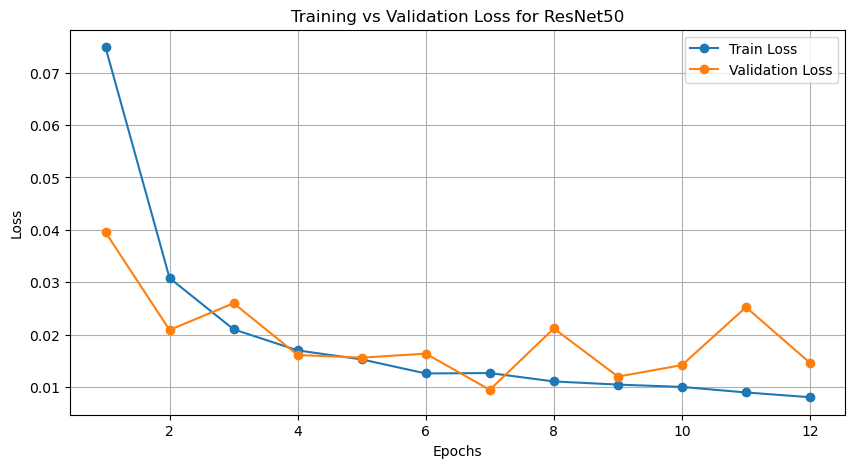

In [18]:
plot_metrics("training_metrics.json", title="Training vs Validation Loss for ResNet50")

RESULTS FROM ThiS MODEL anD SO ON AND FORWARD

### **ResNet50 with more augmentations**

I will be performing the same Resnet50 model implementation. Augmentations are now gonna be these because this and that(ch answer)

### **EfficientNet-b0**

### **EfficientNet-b0 with more augmentations**

### **MobileNet-V2**

### **ConvNeXt-tiny**

### **Visual-Transformer(ViT)- Base (Vit B_16)**

## **References**

[1] Stephan Bohm, S., CAEBUS Center of Advanced E-Business Studies, & RheinMain University of Applied Sciences. (n.d.). HumanPerception and Classification of AI-Generated Images: APre-Study based on a sample from the media sector in Germany. In ThinkMind [Research paper]. The First International Conference on Generative Pre-trained Transformer Models and Beyond, Wiesbaden, Germany. https://www.thinkmind.org/articles/gptmb_2024_1_20_38004.pdf 

[2] Goodfellow, I. J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014, June 10). Generative adversarial networks. arXiv.org. https://arxiv.org/abs/1406.2661

[3] Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B. (2021, December 20). High-Resolution Image Synthesis with Latent Diffusion Models. arXiv.org. https://arxiv.org/abs/2112.10752

[4] Van Waning, J. (2024). Human Art vs AI Art, a Potential Danger for Artist? : Artistic and Economic Evaluations across Multiple Art Genres. In B. Liefooghe, Social, Health and Organizational Psychology. https://studenttheses.uu.nl/bitstream/handle/20.500.12932/47294/Thesis_JoA%cc%83%c2%ablvanWaning%202.pdf?sequence=1&isAllowed=y

[5] Kamali, N., Nakamura, K., Chatzimparmpas, A., Hullman, J., & Groh, M. (2024, June 12). How to Distinguish AI-Generated Images from Authentic Photographs. arXiv.org. https://arxiv.org/abs/2406.08651

[6] Bird, J. J., & Lotfi, A. (2023, March 24). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images. arXiv.org. https://arxiv.org/abs/2303.14126

[7] Ediboglu Bartos, G., & Akyol, S. (4 C.E.). Deep learning for image authentication [Alba Regia Technical Faculty Obuda University]. https://www.researchgate.net/publication/375952278_Deep_Learning_for_Image_Authentication_A_Comparative_Study_on_Real_and_AI-Generated_Image_Classification

[8] He, K., Zhang, X., Ren, S., & Sun, J. (2015, December 10). Deep residual learning for image recognition. arXiv.org. https://arxiv.org/abs/1512.03385

[9] O’Shea, K., & Nash, R. (2015, November 26). An introduction to convolutional neural networks. arXiv.org. https://arxiv.org/abs/1511.08458

[10] Maruthiram, B., Venkataramireddy, .G. Venkataramireddy, & Klick, M. K. (2024). Real VS AI Generated Image Detection and  Classification. International Journal of Innovative Research in Technology (IJIRT), 11(2), ISSN: 2349-6002. https://ijirt.org/publishedpaper/IJIRT166462_PAPER.pdf

[11] Kingma, D. P., & Welling, M. (2013, December 20). Auto-Encoding variational Bayes. arXiv.org. https://arxiv.org/abs/1312.6114

[12] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2020, October 22). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. arXiv.org. https://arxiv.org/abs/2010.11929

[13] Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2019). Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization. International Journal of Computer Vision, 128(2), 336–359. https://doi.org/10.1007/s11263-019-01228-7